# Figure 4

In [1]:
import warnings

import numpy as np
import xarray as xr
import scipy.stats as stats
import metpy.calc as mpcalc
import matplotlib.pyplot as plt

import ppe_plot as ppeplot
import ppe_load as ppeload

%load_ext watermark
%watermark -iv

metpy     : 1.6.0
matplotlib: 3.8.0
xarray    : 2023.10.1
numpy     : 1.24.4
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
scipy     : 1.11.3



In [3]:
# Get plotting settings
ppeplot.setup_plotting_workspace()

## Load model output

In [4]:
# Get area weights
cesm_weights = xr.open_dataset("/glade/work/bbuchovecky/PPE_analysis/weights/COUP_PPE_weights_atmgrid.nc", decode_timedelta=True).rename({"globweights": "globalweights"})
assert cesm_weights.landweights.sum(dim=["lat", "lon"]) == 1

hadcm_weights = xr.open_dataset('/glade/work/bbuchovecky/HadCM3_analysis/weights/HadCM3_weights_v2.nc', decode_timedelta=True)
assert hadcm_weights.landweights.sum(dim=["lat", "lon"]) == 1

# Identify variables to load
varlist = ["T_S", "P", "ET", "RH_S"]

# Load time-mean variables
cesm_ppe, cesm_ctl = ppeload.get_cesm(varlist, "time_mean")
hadhst_ppe, hadhst_ctl = ppeload.get_hadcm(varlist, "control", "time_mean")
hada1b_ppe, hada1b_ctl = ppeload.get_hadcm(varlist, "a1b", "time_mean")
dict_cmip_co2, dict_cmip_pi, dict_cmip_weights = ppeload.get_cmip(varlist, "time_mean")

# Store list of CMIP model names
cmip_models = list(dict_cmip_co2.keys())

# Interpolate CMIP variables to a common grid
dlat = 1.9
dlon = 2.50
new_lat = np.arange(-90, 90+dlat, dlat)
new_lon = np.arange(0, 360, dlon)

cmip_landfrac = dict_cmip_weights['CESM2']['landfrac'].interp(lon=new_lon, lat=new_lat, method='linear')

cmip_co2 = dict()
cmip_pi = dict()

for v in varlist:
    co2_list = []
    pi_list = []

    for m in cmip_models:
        co2_list.append(dict_cmip_co2[m][v].interp(lon=new_lon, lat=new_lat, method='linear'))
        pi_list.append(dict_cmip_pi[m][v].interp(lon=new_lon, lat=new_lat, method='linear'))
    
    cmip_co2[v] = xr.concat(co2_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models))
    cmip_pi[v] = xr.concat(pi_list, dim='model', coords='minimal', compat='override').assign_coords(model=np.arange(7), model_name=("model", cmip_models))

# Compute the delta (perturbed - control)
cesm_delta = dict()
hadhst_delta = dict()
hada1b_delta = dict()
cmip_delta = dict()

for v in varlist:
    cesm_delta[v] = cesm_ppe[v] - cesm_ctl[v]
    hadhst_delta[v] = hadhst_ppe[v] - hadhst_ctl[v]
    hada1b_delta[v] = hada1b_ppe[v] - hada1b_ctl[v]
    cmip_delta[v] = cmip_co2[v] - cmip_pi[v]

    cmip_delta[v] = cmip_delta[v].stack(member=['model', 'experiment'])

# Compute the land and ocean mean
cesm_ppe_areamean = dict()
hadhst_ppe_areamean = dict()
hada1b_ppe_areamean = dict()
cmip_co2_areamean = dict()

cesm_ctl_areamean = dict()
hadhst_ctl_areamean = dict()
hada1b_ctl_areamean = dict()
cmip_pi_areamean = dict()

cesm_delta_areamean = dict()
hadhst_delta_areamean = dict()
hada1b_delta_areamean = dict()
cmip_delta_areamean = dict()
cmip_areamean = dict()

for w, weight in zip(["lm", "om"], ["landweights", "oceanweights"]):
    try:
        cesm_delta_areamean[w];
    except KeyError:
        cesm_ppe_areamean[w] = dict()
        hadhst_ppe_areamean[w] = dict()
        hada1b_ppe_areamean[w] = dict()
        cmip_co2_areamean[w] = dict()

        cesm_ctl_areamean[w] = dict()
        hadhst_ctl_areamean[w] = dict()
        hada1b_ctl_areamean[w] = dict()
        cmip_pi_areamean[w] = dict()

        cesm_delta_areamean[w] = dict()
        hadhst_delta_areamean[w] = dict()
        hada1b_delta_areamean[w] = dict()
        cmip_delta_areamean[w] = dict()
        cmip_areamean[w] = dict()

    assert np.round(cesm_weights[weight].sum(), 3) == 1.
    assert np.round(hadcm_weights[weight].sum(), 3) == 1.

    for v in varlist:
        cesm_ppe_areamean[w][v] = cesm_ppe[v].weighted(cesm_weights[weight]).mean(dim=["lat", "lon"])
        hadhst_ppe_areamean[w][v] = hadhst_ppe[v].weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])
        hada1b_ppe_areamean[w][v] = hada1b_ppe[v].weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])
        
        cesm_ctl_areamean[w][v] = cesm_ctl[v].weighted(cesm_weights[weight]).mean(dim=["lat", "lon"])
        hadhst_ctl_areamean[w][v] = hadhst_ctl[v].weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])
        hada1b_ctl_areamean[w][v] = hada1b_ctl[v].weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])

        cesm_delta_areamean[w][v] = (cesm_ppe[v] - cesm_ctl[v]).weighted(cesm_weights[weight]).mean(dim=["lat", "lon"])
        hadhst_delta_areamean[w][v] = (hadhst_ppe[v] - hadhst_ctl[v]).weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])
        hada1b_delta_areamean[w][v] = (hada1b_ppe[v] - hada1b_ctl[v]).weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])

        cmip_co2_list = []
        cmip_pi_list = []
        cmip_delta_list = []
        cmip_list = []
        for m in cmip_models:
            assert np.round(dict_cmip_weights[m][weight].sum(), 4) == 1.
            co2 = dict_cmip_co2[m][v].weighted(dict_cmip_weights[m][weight]).mean(dim=["lat", "lon"])
            pi = dict_cmip_pi[m][v].weighted(dict_cmip_weights[m][weight]).mean(dim=["lat", "lon"])
            cmip_co2_list.append(co2)
            cmip_pi_list.append(pi)
            cmip_delta_list.append(co2 - pi)
            cmip_list.append(xr.concat([pi.assign_coords(experiment=0),co2.assign_coords(experiment=[1,2,3])], dim="experiment"))
        cmip_co2_areamean[w][v] = xr.concat(cmip_co2_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models))
        cmip_pi_areamean[w][v] = xr.concat(cmip_pi_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models))
        cmip_delta_areamean[w][v] = xr.concat(cmip_delta_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models))
        cmip_areamean[w][v] = xr.concat(cmip_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models))


# Compute \delta (P-E)
for w in ["lm", "om"]:
    cesm_delta_areamean[w]["PmE"] = cesm_delta_areamean[w]["P"] - cesm_delta_areamean[w]["ET"]
    hadhst_delta_areamean[w]["PmE"] = hadhst_delta_areamean[w]["P"] - hadhst_delta_areamean[w]["ET"]
    hada1b_delta_areamean[w]["PmE"] = hada1b_delta_areamean[w]["P"] - hada1b_delta_areamean[w]["ET"]
    cmip_delta_areamean[w]["PmE"] = cmip_delta_areamean[w]["P"] - cmip_delta_areamean[w]["ET"]

## Load CESM2 PI PPE output for \delta (P-E) scaling
print("\ndelta (P-E) scaling for CESM2 PI")

# Load climatologies
Ta_s_ppe_mon, Ta_s_ctl_mon = ppeload.load_cesm_da("TREFHT", "cam", "climatology", "climatology", cesm_weights)
Q_ppe_mon, Q_ctl_mon = ppeload.load_cesm_da("Q", "cam", "climatology", "climatology", cesm_weights)
H_s_ppe_mon, H_s_ctl_mon = ppeload.load_cesm_da("calculated_RHREFHT", "cam", "climatology", "climatology", cesm_weights)
P_ppe_mon, P_ctl_mon = ppeload.load_cesm_da("calculated_PRECT", "cam", "climatology", "climatology", cesm_weights)
LH_ppe_mon, LH_ctl_mon = ppeload.load_cesm_da("LHFLX", "cam", "climatology", "climatology", cesm_weights)
p_s_ppe_mon, p_s_ctl_mon = ppeload.load_cesm_da("PS", "cam", "climatology", "climatology", cesm_weights)
U_ppe_mon, U_ctl_mon = ppeload.load_cesm_da("U", "cam", "climatology", "climatology", cesm_weights)
V_ppe_mon, V_ctl_mon = ppeload.load_cesm_da("V", "cam", "climatology", "climatology", cesm_weights)

# Sort by member
da_names_to_sort = [
    "Ta_s_ppe_mon",
    "Q_ppe_mon",
    "H_s_ppe_mon",
    "P_ppe_mon",
    "LH_ppe_mon",
    "p_s_ppe_mon",
    "U_ppe_mon",
    "V_ppe_mon",
]

for var_name in da_names_to_sort:
    if var_name in globals():
        var = globals()[var_name]
        if hasattr(var, 'member'):
            globals()[var_name] = var.sortby('member')

# Set units to use
units = "W/m2"

# Deal with unit conversions
if units == "W/m2":
    print(f"delta (P-E) scaling units = {units}")

    # Keep energy units for evaporation
    assert LH_ppe_mon.attrs["units"] == "W/m2"
    E_ppe_mon = LH_ppe_mon

    assert LH_ctl_mon.attrs["units"] == "W/m2"
    E_ctl_mon = LH_ctl_mon

    # Convert water units to energy units for precipitation
    assert P_ppe_mon.attrs["units"] == "mm/day"
    P_ppe_mon = P_ppe_mon * 2.26e6 / (60 * 60 * 24)
    P_ppe_mon.attrs["units"] = "W/m2"

    assert P_ctl_mon.attrs["units"] == "mm/day"
    P_ctl_mon = P_ctl_mon * 2.26e6 / (60 * 60 * 24)
    P_ctl_mon.attrs["units"] = "W/m2"

else:
    raise Exception("delta (P-E) scaling units need to be W/m2")

# Compute annual mean
month_length = xr.DataArray(
    data=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
    coords={"month": np.arange(1,13)})

Ta_s_ppe = Ta_s_ppe_mon.weighted(month_length).mean(dim="month")
Ta_s_ctl = Ta_s_ctl_mon.weighted(month_length).mean(dim="month")

Q_ppe = Q_ppe_mon.weighted(month_length).mean(dim="month")
Q_ctl = Q_ctl_mon.weighted(month_length).mean(dim="month")

H_s_ppe= H_s_ppe_mon.weighted(month_length).mean(dim="month")
H_s_ctl= H_s_ctl_mon.weighted(month_length).mean(dim="month")

P_ppe = P_ppe_mon.weighted(month_length).mean(dim="month")
P_ctl = P_ctl_mon.weighted(month_length).mean(dim="month")

E_ppe = E_ppe_mon.weighted(month_length).mean(dim="month")
E_ctl = E_ctl_mon.weighted(month_length).mean(dim="month")

p_s_ppe = p_s_ppe_mon.weighted(month_length).mean(dim="month")
p_s_ctl = p_s_ctl_mon.weighted(month_length).mean(dim="month")

U_ppe = U_ppe_mon.weighted(month_length).mean(dim="month")
U_ctl = U_ctl_mon.weighted(month_length).mean(dim="month")

V_ppe = V_ppe_mon.weighted(month_length).mean(dim="month")
V_ctl = V_ctl_mon.weighted(month_length).mean(dim="month")

P_E_ppe = P_ppe - E_ppe
P_E_ctl = P_ctl - E_ctl

# Compute deltas
delta_Ta_s = Ta_s_ppe - Ta_s_ctl
delta_Q = Q_ppe - Q_ctl
delta_H_s = H_s_ppe - H_s_ctl
delta_P = P_ppe - P_ctl
delta_E = E_ppe - E_ctl
delta_P_E = P_E_ppe - P_E_ctl
delta_U = U_ppe - U_ctl
delta_V = V_ppe - V_ctl

# Compute land mean of deltas
delta_Ta_s_lm = delta_Ta_s.weighted(cesm_weights.landweights).mean(dim=["lat", "lon"])
delta_Q_lm = delta_Q.weighted(cesm_weights.landweights).mean(dim=["lat", "lon"])
delta_H_s_lm = delta_H_s.weighted(cesm_weights.landweights).mean(dim=["lat", "lon"])
delta_P_lm = delta_P.weighted(cesm_weights.landweights).mean(dim=["lat", "lon"])
delta_E_lm = delta_E.weighted(cesm_weights.landweights).mean(dim=["lat", "lon"])
delta_P_E_lm = delta_P_E.weighted(cesm_weights.landweights).mean(dim=["lat", "lon"])

# Get the layer pressure thicknesses for vertical integrals -> pi(k) = hyai(k)*PO + hybi(k)*PS
tmp  = xr.open_dataset("/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/atm/hist/COUP0000_PI_SOM.cam.h0.0049-01.nc")
lev = tmp.lev
hyai = tmp.hyai
hybi = tmp.hybi
P0   = tmp.P0
del tmp

# Compute the pressure interface levels
# NOTE: units of Pa throughout
p_s_ctl = p_s_ctl_mon.weighted(month_length).mean(dim="month")
p_s_i = p_s_ctl.expand_dims({"ilev": hyai["ilev"]})
p_i = hyai * P0 + hybi * p_s_i

# Compute the pressure level deltas and reassign the pressure coordinate to 
# hybrid-sigma level at midpoints to match other variables
dplev = p_i.diff(dim="ilev").rename({"ilev":"lev"}).assign_coords(lev=lev)
dplev.attrs.update(units="Pa", long_name="layer pressure thickness")

# Check that all pressure thicknesses are non-negative
assert float(dplev.min()) >= 0

CESM2 time_mean:
  T_S
  P
  ET
  RH_S
HadCM3 control time_mean:
  T_S
  P
  ET
  RH_S
HadCM3 a1b time_mean:
  T_S
  P
  ET
  RH_S
CMIP6 time_mean:
  CESM2 -- T_S, P, ET, RH_S, 
  CanESM5 -- T_S, P, ET, RH_S, 
  GISS-E2-1-G -- T_S, P, ET, RH_S, 
  HadGEM3-GC31-LL -- T_S, P, ET, RH_S, 
  IPSL-CM6A-LR -- T_S, P, ET, RH_S, 
  MIROC6 -- T_S, P, ET, RH_S, 
  MRI-ESM2-0 -- T_S, P, ET, RH_S, 


delta (P-E) scaling for CESM2 PI
delta (P-E) scaling units = W/m2


## Compute the moisture budget scaling terms

In [5]:
# Constants
Lv = 2.5e6
Rv = 461.5
g  = 9.81

# Load F computed from CESM2-LE by Dave Bonan
ds = xr.open_dataset("/glade/work/bbuchovecky/PPE_analysis/scalings/CESM2-LE-1850-1880-F_u-F_v.nc")

F_u = ds["F_u"]  # W/m
F_v = ds["F_v"]  # W/m

lon = ds["lon"]
lon.attrs["units"] = "degrees"

lat = ds["lat"]
lat.attrs["units"] = "degrees"

dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

# Clausius-Clapeyron scaling term
alpha_s = Lv / Rv / Ta_s_ctl**2  # Ta_s_ctl in K

# Compute the mean dynamic term
integral_q_delta_u = (Q_ctl * delta_U * dplev / g).sum(dim="lev") # kg m^-1 s^-1
integral_q_delta_v = (Q_ctl * delta_V * dplev / g).sum(dim="lev")  # kg m^-1 s^-1

d_q_delta_u_dx = []
d_q_delta_v_dy = []

gradient_y_alpha_Ta_s = []  # 1/m
gradient_x_alpha_Ta_s = []  # 1/m

gradient_y_delta_H_s_H_s = []  # 1/m
gradient_x_delta_H_s_H_s = []  # 1/m

for m in range(36):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        data = alpha_s * delta_Ta_s.isel(member=m)
        grad_y, grad_x = mpcalc.gradient(data, deltas=(dy, dx))
        gradient_y_alpha_Ta_s.append(xr.DataArray(grad_y.magnitude, dims=["lat", "lon"], coords={"lat":lat, "lon":lon}))
        gradient_x_alpha_Ta_s.append(xr.DataArray(grad_x.magnitude, dims=["lat", "lon"], coords={"lat":lat, "lon":lon}))

        data = delta_H_s.isel(member=m) / H_s_ctl
        grad_y, grad_x = mpcalc.gradient(data, deltas=(dy, dx))
        gradient_y_delta_H_s_H_s.append(xr.DataArray(grad_y.magnitude, dims=["lat", "lon"], coords={"lat":lat, "lon":lon}))
        gradient_x_delta_H_s_H_s.append(xr.DataArray(grad_x.magnitude, dims=["lat", "lon"], coords={"lat":lat, "lon":lon}))

        data = (integral_q_delta_u).isel(member=m)
        _, grad_x = mpcalc.gradient(data, deltas=(dy, dx))  # kg m^-2 s^-1
        d_q_delta_u_dx.append(xr.DataArray(grad_x.magnitude, dims=["lat", "lon"], coords={"lat":lat, "lon":lon}))

        data = (integral_q_delta_v).isel(member=m)
        grad_y, _ = mpcalc.gradient(data, deltas=(dy, dx))  # kg m^-2 s^-1
        d_q_delta_v_dy.append(xr.DataArray(grad_y.magnitude, dims=["lat", "lon"], coords={"lat":lat, "lon":lon}))

gradient_y_alpha_Ta_s = xr.concat(gradient_y_alpha_Ta_s, dim="member").assign_coords({"member":Ta_s_ppe.member})
gradient_x_alpha_Ta_s = xr.concat(gradient_x_alpha_Ta_s, dim="member").assign_coords({"member":Ta_s_ppe.member})

gradient_y_delta_H_s_H_s = xr.concat(gradient_y_delta_H_s_H_s, dim="member").assign_coords({"member":Ta_s_ppe.member})
gradient_x_delta_H_s_H_s = xr.concat(gradient_x_delta_H_s_H_s, dim="member").assign_coords({"member":Ta_s_ppe.member})

d_q_delta_u_dx = xr.concat(d_q_delta_u_dx, dim="member").assign_coords({"member":delta_U.member})
d_q_delta_v_dy = xr.concat(d_q_delta_v_dy, dim="member").assign_coords({"member":delta_V.member})

# Compute each term
term1 = alpha_s * delta_Ta_s * (P_ctl - E_ctl)  # W/m2
term2 = (delta_H_s / H_s_ctl) * (P_ctl - E_ctl)  # W/m2
term3 = - F_u * gradient_x_alpha_Ta_s - F_v * gradient_y_alpha_Ta_s  # W/m2
term4 = - F_u * gradient_x_delta_H_s_H_s - F_v * gradient_y_delta_H_s_H_s  # W/m2

# Compute the total gradient and convert kg m^-2 s^-1 to W m^-2
term5 = - (d_q_delta_u_dx + d_q_delta_v_dy) * Lv # W/m2

# Compute the land mean
term1_lm = term1.weighted(cesm_weights.landweights).mean(dim=["lat", "lon"])
term2_lm = term2.weighted(cesm_weights.landweights).mean(dim=["lat", "lon"])
term3_lm = term3.weighted(cesm_weights.landweights).mean(dim=["lat", "lon"])
term4_lm = term4.weighted(cesm_weights.landweights).mean(dim=["lat", "lon"])
term5_lm = term5.weighted(cesm_weights.landweights).mean(dim=["lat", "lon"])
allterms_lm = term1_lm + term2_lm + term3_lm + term4_lm + term5_lm

# Compute the predicted \delta P_L from \delta E_L and predicted \delta (P-E)_L
delta_E_allterms_lm = delta_E_lm + allterms_lm

# Regress each term against the actual \delta (P-E)
one_to_one_delta_P_E = dict()
for name, da in zip(["term1", "term2", "term3", "term4", "term5", "allterms"], [term1_lm, term2_lm, term3_lm, term4_lm, term5_lm, allterms_lm]):
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(delta_P_E_lm, da)
    rmse = np.sqrt(((delta_P_E_lm - da) ** 2).mean())
    one_to_one_delta_P_E[name] = dict(slope=slope, intercept=intercept, rvalue=rvalue, pvalue=pvalue, stderr=stderr, rmse=rmse.item())

# Regress each term against the actual \delta P
one_to_one_delta_P = dict()
for name, da in zip(["delta_E", "term1", "term2", "term3", "term4", "term5", "allterms", "delta_E_allterms"], [delta_E_lm, term1_lm, term2_lm, term3_lm, term4_lm, term5_lm, allterms_lm, delta_E_allterms_lm]):
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(delta_P_lm, da)
    rmse = np.sqrt(((delta_P_lm - da) ** 2).mean())
    one_to_one_delta_P[name] = dict(slope=slope, intercept=intercept, rvalue=rvalue, pvalue=pvalue, stderr=stderr, rmse=rmse.item())

## Compute precipitation change from the compositing scheme approach

In [6]:
lat_bounds = {
    "global": (-90, 90),
    "trop": (-30, 30),
    "nh": (30, 90),
    "nhmid": (30, 60)
}

cmip_co2_areamean_lat = dict()
cmip_pi_areamean_lat = dict()
cmip_delta_areamean_lat = dict()
cmip_areamean_lat = dict()

lr = dict()

for key, lat in lat_bounds.items():
    cmip_co2_areamean_lat[key] = dict()
    cmip_pi_areamean_lat[key] = dict()
    cmip_delta_areamean_lat[key] = dict()
    cmip_areamean_lat[key] = dict()

    for w, weight in zip(["lm", "om"], ["landweights", "oceanweights"]):
        cmip_co2_areamean_lat[key][w] = dict()
        cmip_pi_areamean_lat[key][w] = dict()
        cmip_delta_areamean_lat[key][w] = dict()
        cmip_areamean_lat[key][w] = dict()
        for v in varlist:
            cmip_co2_list = []
            cmip_pi_list = []
            cmip_delta_list = []
            cmip_list = []
            for m in cmip_models:
                assert np.round(dict_cmip_weights[m][weight].sum(), 4) == 1.
                co2 = dict_cmip_co2[m][v].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(dict_cmip_weights[m][weight]).mean(dim=["lat", "lon"])
                pi = dict_cmip_pi[m][v].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(dict_cmip_weights[m][weight]).mean(dim=["lat", "lon"])
                cmip_co2_list.append(co2)
                cmip_pi_list.append(pi)
                cmip_delta_list.append(co2 - pi)
                cmip_list.append(xr.concat([pi.assign_coords(experiment=0), co2.assign_coords(experiment=[1,2,3])], dim="experiment").assign_coords(experiment_name=("experiment", ["PI", "0p5xCO2", "2xCO2", "4xCO2"])))
            cmip_co2_areamean_lat[key][w][v] = xr.concat(cmip_co2_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models))
            cmip_pi_areamean_lat[key][w][v] = xr.concat(cmip_pi_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models))
            cmip_delta_areamean_lat[key][w][v] = xr.concat(cmip_delta_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models))
            cmip_areamean_lat[key][w][v] = xr.concat(cmip_list, dim='model', coords='minimal', compat='override').assign_coords(model=("model", np.arange(7)), model_name=("model", cmip_models))

    ## Estimate the coefficients a_0 and a_1 with linear regression
    lr[key] = dict()

    ## PPEs
    for name, ppe, ctl, weights in zip(
        ["cesm", "hadhst", "hada1b"],
        [cesm_ppe, hadhst_ppe, hada1b_ppe],
        [cesm_ctl, hadhst_ctl, hada1b_ctl],
        [cesm_weights.fillna(0), hadcm_weights.fillna(0), hadcm_weights.fillna(0)]):

        ppe_P_L = ppe["P"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.landweights).mean(dim=["lat", "lon"])
        ppe_P_O = ppe["P"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.oceanweights).mean(dim=["lat", "lon"])
        ppe_RH_SL = ppe["RH_S"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.landweights).mean(dim=["lat", "lon"]) / 100
        ppe_RH_SO = ppe["RH_S"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.oceanweights).mean(dim=["lat", "lon"]) / 100

        ppe_P_L = ppe_P_L.sortby("member")
        ppe_P_O = ppe_P_O.sortby("member")
        ppe_RH_SL = ppe_RH_SL.sortby("member")
        ppe_RH_SO = ppe_RH_SO.sortby("member")

        x = ppe_RH_SL - ppe_RH_SO
        y = ppe_P_L / ppe_P_O

        x = x.sortby(x)
        y = y.sortby(y)
        lr[key][name] = {"x": x, "y": y, "lr": stats.linregress(x, y)}

    ## CMIP6 CO2 ensemble
    x = cmip_areamean_lat[key]["lm"]["RH_S"]/100 - cmip_areamean_lat[key]["om"]["RH_S"]/100
    y = cmip_areamean_lat[key]["lm"]["P"] / cmip_areamean_lat[key]["om"]["P"]
    for i, m in enumerate(cmip_models):
        xi = x.isel(model=i)
        yi = y.isel(model=i)
        xii = xi.sortby(xi)
        lr[key][m+"_CO2"] = {"x": xi, "y": yi, "lr": stats.linregress(xi, yi)}

In [7]:
def compute_delta_p_scaling(a_1, rh_l_pert, rh_o_pert, p_o_pert, rh_l_ctrl, rh_o_ctrl, p_o_ctrl):
    return a_1 * (((rh_l_pert - rh_o_pert) * p_o_pert) - ((rh_l_ctrl - rh_o_ctrl) * p_o_ctrl))

def compute_approx_delta_p_scaling(a_1, rh_l_pert, rh_o_pert, rh_l_ctrl, rh_o_ctrl, p_o_ctrl):
    return a_1 * (((rh_l_pert - rh_o_pert) * p_o_ctrl) - ((rh_l_ctrl - rh_o_ctrl) * p_o_ctrl))

delta_p_scaling = dict()

for key, lat in lat_bounds.items():
    delta_p_scaling[key] = dict()

    for name, ppe, ctl, weights in zip(
        ["cesm", "hadhst", "hada1b"],
        [cesm_ppe, hadhst_ppe, hada1b_ppe],
        [cesm_ctl, hadhst_ctl, hada1b_ctl],
        [cesm_weights.fillna(0), hadcm_weights.fillna(0), hadcm_weights.fillna(0)]):

        ppe_P_L = ppe["P"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.landweights).mean(dim=["lat", "lon"])
        ppe_P_O = ppe["P"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.oceanweights).mean(dim=["lat", "lon"])
        ppe_RH_SL = ppe["RH_S"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.landweights).mean(dim=["lat", "lon"]) / 100
        ppe_RH_SO = ppe["RH_S"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.oceanweights).mean(dim=["lat", "lon"]) / 100
        ctl_P_L = ctl["P"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.landweights).mean(dim=["lat", "lon"])
        ctl_P_O = ctl["P"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.oceanweights).mean(dim=["lat", "lon"])
        ctl_RH_SL = ctl["RH_S"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.landweights).mean(dim=["lat", "lon"]) / 100
        ctl_RH_SO = ctl["RH_S"].sortby("lat").sel(lat=slice(lat[0], lat[1])).weighted(weights.oceanweights).mean(dim=["lat", "lon"]) / 100

        ppe_P_L = ppe_P_L.sortby("member")
        ppe_P_O = ppe_P_O.sortby("member")
        ppe_RH_SL = ppe_RH_SL.sortby("member")
        ppe_RH_SO = ppe_RH_SO.sortby("member")

        delta_P_L = ppe_P_L - ctl_P_L
        delta_RH_SL = ppe_RH_SL - ctl_RH_SL
        delta_RH_SO = ppe_RH_SO - ctl_RH_SO

        _delta_p_scaling = compute_delta_p_scaling(
            lr[key][name]["lr"].slope, ppe_RH_SL, ppe_RH_SO, ppe_P_O, ctl_RH_SL, ctl_RH_SO, ctl_P_O,
        )

        _delta_p_scaling = compute_approx_delta_p_scaling(
            lr[key][name]["lr"].slope, ppe_RH_SL, ppe_RH_SO, ctl_RH_SL, ctl_RH_SO, ctl_P_O,
        )

        slope, intercept, rvalue, pvalue, stderr = stats.linregress(delta_P_L, _delta_p_scaling)
        rmse = np.sqrt(((delta_P_L - _delta_p_scaling) ** 2).mean())
        full = dict(
            data=_delta_p_scaling,
            slope=slope,
            intercept=intercept,
            r_value=rvalue,
            p_value=pvalue,
            std_err=stderr,
            rmse=rmse.item(),
        )

        slope, intercept, rvalue, pvalue, stderr = stats.linregress(delta_P_L, _delta_p_scaling)
        rmse = np.sqrt(((delta_P_L - _delta_p_scaling) ** 2).mean())
        full_approx = dict(
            data=_delta_p_scaling,
            slope=slope,
            intercept=intercept,
            r_value=rvalue,
            p_value=pvalue,
            std_err=stderr,
            rmse=rmse.item(),
        )

        delta_rh_l_term = lr[key][name]["lr"].slope * delta_RH_SL * ctl_P_O
        slope, intercept, rvalue, pvalue, stderr = stats.linregress(delta_P_L, delta_rh_l_term)
        rmse = np.sqrt(((delta_P_L - delta_rh_l_term) ** 2).mean())
        delta_rh_l_term = dict(
            data=delta_rh_l_term,
            slope=slope,
            intercept=intercept,
            r_value=rvalue,
            p_value=pvalue,
            std_err=stderr,
            rmse=rmse.item(),
        )

        delta_rh_o_term = lr[key][name]["lr"].slope * delta_RH_SO * ctl_P_O
        slope, intercept, rvalue, pvalue, stderr = stats.linregress(delta_P_L, -delta_rh_o_term)
        rmse = np.sqrt(((delta_P_L - delta_rh_o_term) ** 2).mean())
        delta_rh_o_term = dict(
            data=delta_rh_o_term,
            slope=slope,
            intercept=intercept,
            r_value=rvalue,
            p_value=pvalue,
            std_err=stderr,
            rmse=rmse.item(),
        )

        delta_p_scaling[key][name] = dict(full=full, full_approx=full_approx, delta_rh_l_term=delta_rh_l_term, delta_rh_o_term=delta_rh_o_term)

## Create the figure

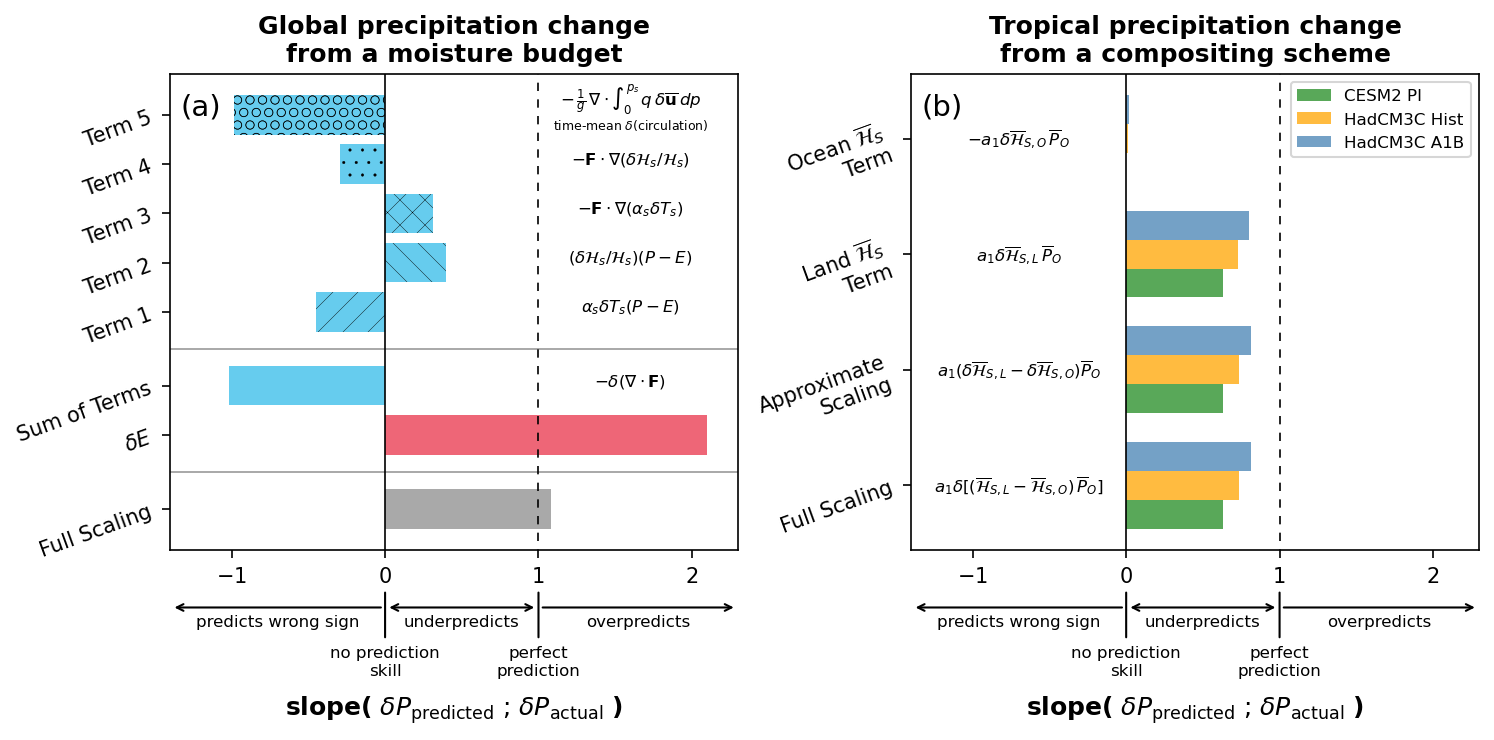

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), layout="tight")
ax = axs.flatten()

########################################################
## Precipitation change the moisture budget scaling
########################################################

x = [0, 1.5, 2.5, 4, 5, 6, 7, 8]
slope = [
    one_to_one_delta_P["delta_E_allterms"]["slope"],
    one_to_one_delta_P["delta_E"]["slope"],
    one_to_one_delta_P["allterms"]["slope"],
    one_to_one_delta_P["term1"]["slope"],
    one_to_one_delta_P["term2"]["slope"],
    one_to_one_delta_P["term3"]["slope"],
    one_to_one_delta_P["term4"]["slope"],
    one_to_one_delta_P["term5"]["slope"],
]
r2 = [
    one_to_one_delta_P["delta_E_allterms"]["rvalue"]**2,
    one_to_one_delta_P["delta_E"]["rvalue"]**2,
    one_to_one_delta_P["allterms"]["rvalue"]**2,
    one_to_one_delta_P["term1"]["rvalue"]**2,
    one_to_one_delta_P["term2"]["rvalue"]**2,
    one_to_one_delta_P["term3"]["rvalue"]**2,
    one_to_one_delta_P["term4"]["rvalue"]**2,
    one_to_one_delta_P["term5"]["rvalue"]**2,
]
rmse = [
    one_to_one_delta_P["delta_E_allterms"]["rmse"],
    one_to_one_delta_P["delta_E"]["rmse"],
    one_to_one_delta_P["allterms"]["rmse"],
    one_to_one_delta_P["term1"]["rmse"],
    one_to_one_delta_P["term2"]["rmse"],
    one_to_one_delta_P["term3"]["rmse"],
    one_to_one_delta_P["term4"]["rmse"],
    one_to_one_delta_P["term5"]["rmse"],
]

yaxis_term = [
    "Full Scaling",
    "$\\delta E$",
    "Sum of Terms",
    "Term 1",
    "Term 2",
    "Term 3",
    "Term 4",
    "Term 5",
]
yaxis_math = [
    "$\\delta E - \\delta (\\nabla \\cdot \\mathbf{F})$",
    "$\\delta E$",
    "$- \\delta (\\nabla \\cdot \\mathbf{F})$",
    "$\\alpha_s \\delta T_s (P-E)$",
    "$(\\delta \\mathcal{H}_s / \\mathcal{H}_s) (P-E)$",
    "$-\\mathbf{F} \\cdot \\nabla (\\alpha_s \\delta T_s)$",
    "$-\\mathbf{F} \\cdot \\nabla (\\delta \\mathcal{H}_s / \\mathcal{H}_s)$",
    "$-\\, \\frac{1}{g} \\, \\nabla \\cdot \\int_0^{p_s} \\, q \\, \\delta \\overline{\\mathbf{u}} \\, dp$",
]
yaxis_text = [
    "$\\delta E - \\delta (\\nabla \\cdot \\mathbf{F})$",
    "$\\delta E$",
    "$- \\delta (\\nabla \\cdot \\mathbf{F})$",
    "local $\\alpha_s \\delta T_s$",
    "local $\\delta \\mathcal{H}_s / \\mathcal{H}_s$",
    "gradients of $\\alpha_s \\delta T_s$",
    "gradients of $\\delta \\mathcal{H}_s / \\mathcal{H}_s$",
    "time-mean $\\delta$(circulation)",
]

ymin = -2
ymax =  2

xmin = -0.5
xmax =  8.5

ax[0].barh(
    x, slope,
    color=["darkgray", "#ee6677", "#66ccee", "#66ccee", "#66ccee", "#66ccee", "#66ccee", "#66ccee", "#66ccee"],
    hatch=["", "", "", "//", "\\\\", "xx", "..", "OO"]
)
ax[0].axhline(0.75, ymin, ymax, color="k", alpha=0.4, ls="-", lw=plt.rcParams["axes.linewidth"])
ax[0].axhline(3.25, ymin, ymax, color="k", alpha=0.4, ls="-", lw=plt.rcParams["axes.linewidth"])
ax[0].set_yticks(x)
ax[0].set_yticklabels(yaxis_term, ha="right", fontsize=10, rotation=20)
for i in range(2,8):
    if i == 7:
        ax[0].text(1.6, x[i]+0.2, yaxis_math[i], ha="center")
        ax[0].text(1.6, x[i]-0.3, yaxis_text[i], ha="center", fontsize=6)
    else:
        ax[0].text(1.6, x[i], yaxis_math[i], ha="center")


########################################################
## Precipitation change from the compositing scheme
########################################################

label = ["CESM2 PI", "HadCM3C Hist", "HadCM3C A1B"]
region = "trop"

x = np.array([0.25, 1.25, 2.25, 3.25])
yaxis = [
    "Ocean $\\overline{\\mathcal{H}}_{S}$\nTerm",
    "Land $\\overline{\\mathcal{H}}_{S}$\nTerm",
    "Approximate\nScaling",
    "Full Scaling"
][::-1]
yaxis_math = [
    "$-a_1 \\delta \\overline{\\mathcal{H}}_{S,O} \, \\overline{P}_O$",
    "$a_1 \\delta \\overline{\\mathcal{H}}_{S,L} \, \\overline{P}_O$",
    "$a_1 (\\delta \\overline{\\mathcal{H}}_{S,L} - \\delta \\overline{\\mathcal{H}}_{S,O}) \\overline{P}_O$",
    "$a_1 \\delta [(\\overline{\\mathcal{H}}_{S,L} - \\overline{\\mathcal{H}}_{S,O}) \, \\overline{P}_O]$",
][::-1]

m = np.zeros((3, 4))
r2 = np.zeros((3, 4))
rmse = np.zeros((3, 4))
for i, (key, item) in enumerate(delta_p_scaling[region].items()):
    m[i] = np.array([
        delta_p_scaling[region][key]["delta_rh_o_term"]["slope"],
        delta_p_scaling[region][key]["delta_rh_l_term"]["slope"],
        delta_p_scaling[region][key]["full_approx"]["slope"],
        delta_p_scaling[region][key]["full"]["slope"],
    ])[::-1]

    r2[i] = np.array([
        delta_p_scaling[region][key]["delta_rh_o_term"]["r_value"]**2,
        delta_p_scaling[region][key]["delta_rh_l_term"]["r_value"]**2,
        delta_p_scaling[region][key]["full_approx"]["r_value"]**2,
        delta_p_scaling[region][key]["full"]["r_value"]**2,
    ])[::-1]

    rmse[i] = np.array([
        delta_p_scaling[region][key]["delta_rh_o_term"]["rmse"],
        delta_p_scaling[region][key]["delta_rh_l_term"]["rmse"],
        delta_p_scaling[region][key]["full_approx"]["rmse"],
        delta_p_scaling[region][key]["full"]["rmse"],
    ])[::-1]

    ax[1].barh(
        x+i/4,
        m[i],
        height=0.25,
        color=ppeplot.c_dict[key],
        label=label[i],
        alpha=0.75
    )

for i in range(4):
    ax[1].text(-0.7, x[i]+0.25, yaxis_math[i], ha="center", va="center")
ax[1].set_yticks(x+0.25)
ax[1].set_yticklabels(yaxis, ha="right", fontsize=10, rotation=20)
ax[1].legend(frameon=True)

for a in ax:
    a.set_xticks([-1.0, 0.0, 1.0, 2.0])
    a.set_xticklabels(["$-$1", "0", "1", "2"], fontsize=10)
    a.set_xlim(-1.4, 2.3)
    a.axvline(1, xmin, xmax, color="k", ls=(0, (5, 5)), lw=plt.rcParams["axes.linewidth"])
    a.axvline(0, xmin, xmax, color="k", ls="-", lw=plt.rcParams["axes.linewidth"])

    trans = a.get_xaxis_transform()
    a.annotate("no prediction\nskill", xy=(0,-0.08), xytext=(0,-0.2), ha="center", va="top", xycoords=trans, arrowprops=dict(arrowstyle='-', color='black'))
    a.annotate("perfect\nprediction", xy=(1,-0.08), xytext=(1,-0.2), ha="center", va="top", xycoords=trans, arrowprops=dict(arrowstyle='-', color='black'))
    a.annotate("", xy=(1,-0.12), xytext=(0,-0.12), xycoords=trans, arrowprops=dict(arrowstyle='<->', color='black'))
    a.annotate("", xy=(0,-0.12), xytext=(-1.4,-0.12), xycoords=trans, arrowprops=dict(arrowstyle='<-', color='black'))
    a.annotate("", xy=(1,-0.12), xytext=(2.3,-0.12), xycoords=trans, arrowprops=dict(arrowstyle='<-', color='black'))
    a.text(x=0.5, y=-0.15, s="underpredicts", ha="center", va="center", fontsize=8, transform=trans)
    a.text(x=-0.7, y=-0.15, s="predicts wrong sign", ha="center", va="center", fontsize=8, transform=trans)
    a.text(x=1.65, y=-0.15, s="overpredicts", ha="center", va="center", fontsize=8, transform=trans)
    a.text(x=0.5, y=-0.3, s="$\\mathbf{slope(}$ $\\delta P_{\\text{predicted}}$ ; $\\delta P_{\\text{actual}}$ $\\mathbf{)}$", ha="center", va="top", fontsize=12, transform=a.transAxes)

ax[0].set_title("Global precipitation change\nfrom a moisture budget", fontsize=12, fontweight="bold", loc="center")
ax[1].set_title("Tropical precipitation change\nfrom a compositing scheme", fontsize=12, fontweight="bold", loc="center")

ax[0].text(x=0.09, y=0.96, s="(a)", fontsize=14, transform=ax[0].transAxes, ha="right", va="top")
ax[1].text(x=0.09, y=0.96, s="(b)", fontsize=14, transform=ax[1].transAxes, ha="right", va="top")

## Save figure
fig.savefig("../figures/main/fig4_bars.pdf")